In [1]:
import numpy as np
import cv2

In [2]:
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

Using TensorFlow backend.


In [6]:
model_mobilenet = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [ ]:
training_set_mobilenet_features = []
for i in list(range(1, 401)) + list(range(501, 901)):
    img_path = 'test8/%06d.png' % i
    # print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))# 读取图片
    
    #plt.imshow(img)
    #plt.show()# 显示图片
    x = image.img_to_array(img)# 图片转换为ndarray
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)# 数组转换为mobilenet输入格式

    training_set_mobilenet_features.append(model_mobilenet.predict(x).reshape((7*7*1024, )))# 计算该张图片的特征

In [ ]:
training_set_mobilenet_features_ndarray = np.vstack(training_set_mobilenet_features)# 转换为ndarray

In [ ]:
training_set_label = np.array([1.0 if i < 400 else 0.0 for i in range(800)])

In [ ]:
test_set_mobilenet_features = []
for i in list(range(401, 501)) + list(range(901, 1001)):
    img_path = 'test8/%06d.png' % i
    # print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))# 读取图片
    x = image.img_to_array(img)# 图片转换为ndarray
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)# 数组转换为mobilenet输入格式

    test_set_mobilenet_features.append(model_mobilenet.predict(x).reshape((7*7*1024, )))# 计算该张图片的特征

In [ ]:
test_set_mobilenet_features_ndarray = np.vstack(test_set_mobilenet_features)# 转换为ndarray

In [ ]:
smoke_dataset_image_1 = np.load('smoke_data/set1_48_data.npy')
smoke_dataset_label_1 = np.load('smoke_data/set1_48_label.npy')
smoke_dataset_image_2 = np.load('smoke_data/set2_48_data.npy')
smoke_dataset_label_2 = np.load('smoke_data/set2_48_label.npy')
smoke_dataset_image_3 = np.load('smoke_data/set3_48_data.npy')
smoke_dataset_label_3 = np.load('smoke_data/set3_48_label.npy')
smoke_dataset_image_4 = np.load('smoke_data/set4_48_data.npy')
smoke_dataset_label_4 = np.load('smoke_data/set4_48_label.npy')

In [ ]:
training_set = np.array([cv2.resize(i, (224, 224)) for i in smoke_dataset_image_1]) * 255

In [ ]:
training_set_mobilenet_features_ndarray = model_mobilenet.predict(preprocess_input(training_set)).reshape((1383, 7*7*1024))

In [ ]:
training_set_label = smoke_dataset_label_1.flatten().astype(np.int64)

In [ ]:
test_set = np.array([cv2.resize(i, (224, 224)) for i in smoke_dataset_image_2]) * 255

In [ ]:
test_set_mobilenet_features_ndarray = model_mobilenet.predict(preprocess_input(test_set)).reshape((1505, 7*7*1024))

In [ ]:
test_set_label = smoke_dataset_label_2.flatten().astype(np.int64)

In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.utils.vis_utils import plot_model

In [2]:
model_smoke_detector = Sequential()
model_smoke_detector.add(Dense(128, activation='sigmoid', input_shape=(7*7*1024, )))# 加入全连接层
model_smoke_detector.add(Dropout(0.5))# 加入dropout防止过拟合
model_smoke_detector.add(Dense(1, activation='sigmoid'))# 加入全连接层

In [3]:
model_smoke_detector.compile(optimizer='rmsprop',
      loss='binary_crossentropy',
      metrics=['accuracy'])
# 定义神经网络损失函数等

In [8]:
plot_model(model_smoke_detector, to_file='model.png', show_shapes=True)
plot_model(model_mobilenet, to_file='mobilenet.png', show_shapes=True)


In [ ]:
model_smoke_detector.fit(training_set_mobilenet_features_ndarray, training_set_label, nb_epoch=10, batch_size=16)
# 拟合数据即训练神经网络

In [ ]:
test_set_mobilenet_with_fc_prediction = model_smoke_detector.predict(test_set_mobilenet_features_ndarray)# 对测试集进行预测

In [ ]:
test_set_mobilenet_with_fc_prediction[test_set_mobilenet_with_fc_prediction >= 0.5] = 1
test_set_mobilenet_with_fc_prediction[test_set_mobilenet_with_fc_prediction < 0.5] = 0
test_set_mobilenet_with_fc_prediction_positive = test_set_mobilenet_with_fc_prediction[test_set_label == 1]
test_set_mobilenet_with_fc_prediction_negative = test_set_mobilenet_with_fc_prediction[test_set_label == 0]

In [ ]:
print('mobilenet+全连接神经网络，测试集\n检验率： {0}, 虚警率： {1}'.format(
    len(test_set_mobilenet_with_fc_prediction_positive[test_set_mobilenet_with_fc_prediction_positive == 1]) / len(test_set_mobilenet_with_fc_prediction_positive),
    len(test_set_mobilenet_with_fc_prediction_negative[test_set_mobilenet_with_fc_prediction_negative == 1]) / len(test_set_mobilenet_with_fc_prediction_negative)))

In [ ]:
model_smoke_detector.save('smoke_detecctor_with_mobilenet.h5')

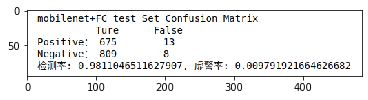

In [3]:
import matplotlib.pyplot as plt
import skimage.io as io
img = io.imread('result/mobilenet_fc_test.png') 
plt.imshow(img)
plt.show()